## Welcome to exercise 03
앞서 배운 것들을 바탕으로 실습을 해봅시다
1) RNN을 LSTM으로 바꿔봅시다 <br>
2) RNN을 ``01_nn_tutorial``을 따라 단계적으로 리팩토링 해봅시다<br>
3) learning curve, embedding을 ``02_Tensorboard``를 따라 tensorboard와 연결해봅시다

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## Data Loading

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
import unicodedata
import string

In [4]:
all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)

In [5]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

In [6]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

In [7]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

## data to Tensor

In [8]:
import torch

In [9]:
# find index of letter
def letterToIndex(letter):
    return all_letters.find(letter)

# 이름(word, line)을 <line_length x 1 x n_letters>로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [10]:
lineToTensor('Jones').shape # 5 -> len('Jones'), 1(batch), 56(len(all_letters))

torch.Size([5, 1, 56])

## Network

In [11]:
from torch import nn

# 1. 네트워크 LSTM으로 바꾸기 

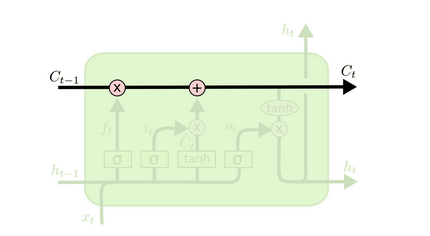

$$ f_t = \sigma(W_f[h_{t-1},x_t]+b_f) $$
$$ i_t = \sigma(W_i[h_{t-1},x_t]+b_i) $$
$$ \tilde{C_t} = tanh(W_c[h_{t-1},x_t]+b_i) $$
$$ C_t = \sigma(f_t * C_{t-1} + i_t * \tilde{C_t}) $$
$$ o_t = \sigma(W_o[h_{t-1}, x_t]+b_o) $$
$$ h_t = tanh(C_t) * o_t $$

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        '''  define weights '''
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size) # input to forget gate
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size) # input to input gate
        self.i2c = nn.Linear(input_size + hidden_size, hidden_size) # input to cell gate
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size) # input to output gate
        self.h2y = nn.Linear(hidden_size, output_size) # hidden to ouput(prediction)
        
        ''' activation functions '''
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
         
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)       
    
    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        
        forget_rate = self.i2f(combined)
        forget_rate = self.sigmoid(forget_rate)
        
        input_rate = self.i2i(combined)
        input_rate = self.sigmoid(input_rate)
        
        cell_tilda = self.i2c(combined)
        cell_tilda = self.tanh(cell_tilda)
        cell = forget_rate * cell + input_rate * cell_tilda 
        
        output_rate = self.i2o(combined)
        output_rate = self.sigmoid(output_rate)
        
        hidden = self.tanh(cell) * output_rate
        
        output = self.h2y(hidden)
        output = self.softmax(output)
        return output, hidden, cell
 

## model instance test

### model parameter 

In [53]:
n_hidden = 128
learning_rate = 0.005
batch_size = 1
input_size = n_letters
output_size = n_categories
epochs = 1
criterion = nn.NLLLoss()

In [54]:
rnn = LSTM(n_letters, n_hidden, n_categories)
input = lineToTensor('Albert')
hidden = torch.zeros(batch_size, n_hidden) # initial hidden statate as zero vector
cell = torch.zeros(batch_size, n_hidden) # initial hidden statate as zero vector
output, next_hidden, next_cell = rnn(input[0], hidden, cell)
output

tensor([[-2.8494, -2.9744, -2.9838, -2.9874, -2.8750, -2.9242, -2.7967, -2.8947,
         -2.8286, -2.8836, -2.9101, -2.9122, -2.8253, -2.8571, -2.8762, -2.9293,
         -2.8761, -2.8673]], grad_fn=<LogSoftmaxBackward>)

## prepare for train

In [55]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 6)


In [56]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Connor
category = Russian / line = Verstakov
category = Czech / line = Macha
category = Dutch / line = Klerkse
category = Japanese / line = Uetake
category = Spanish / line = Moreno
category = Japanese / line = Masanobu
category = Irish / line = Doyle
category = Greek / line = Polymenakou
category = Vietnamese / line = Chau


## train network 

In [57]:
def train(category_tensor, line_tensor):
    # 한 배치에 대한 train 코드
    hidden = rnn.initHidden() # hidden layer 초기화
    cell = rnn.initHidden() # cell layer 초기화

    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden, cell = rnn(line_tensor[i], hidden, cell) 
        # 글자마다 output은 나오는데 for문에서는 hidden만 사용되고
    
    # for 문이 끝나면 output이 평가됨
    criterion = nn.NLLLoss()
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss

In [58]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 19s) 2.8836 Spannagel / English ✗ (German)
10000 10% (0m 37s) 2.9016 Raskoph / Irish ✗ (German)
15000 15% (0m 55s) 2.8541 Andringa / Czech ✗ (Dutch)
20000 20% (1m 14s) 2.8754 Handal / Irish ✗ (Arabic)
25000 25% (1m 32s) 2.8058 Hoffman / Czech ✗ (German)
30000 30% (1m 50s) 2.6414 Bonhomme / Russian ✗ (French)
35000 35% (2m 8s) 2.4022 Ikeda / Japanese ✓
40000 40% (2m 26s) 2.7514 Rochford / Dutch ✗ (English)
45000 45% (2m 45s) 3.1269 Rompaeij / Italian ✗ (Dutch)
50000 50% (3m 4s) 0.2787 Leontarakis / Greek ✓
55000 55% (3m 22s) 1.4903 Assaf / Arabic ✓
60000 60% (3m 40s) 1.0860 Gniewek / Polish ✓


KeyboardInterrupt: 

## learning curve

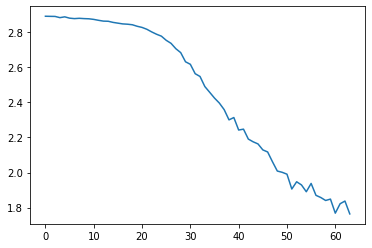

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## evaluation ( metrics )  

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    cell = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

KeyboardInterrupt: 

# 2. refactoring 

TensorDataset에 넣기 위해서 train, test 셋을 나누고, 캐릭터를 원핫인코딩하여 텐서로 바꾸고 나라 카테고리를 숫자로 바꾸는 전처리가 필요함(아래의 코드와 같음)<br>
그래서 이와 같은 과정을 한번에 할 수 있는 사용자 Dataset을 정의하는 것이 효율적으로 보임

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import Dataset

In [ ]:
le = preprocessing.LabelEncoder()
le = le.fit(all_categories)

In [ ]:
x = []
y = []
for key, value in category_lines.items():
    for v in value:
        x.append(v)
        y.append(key)

In [ ]:
# y = le.transform(y)
# y = y.astype(np.float64)
# y = torch.Tensor(y)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y)

## 1) 사용자 DataSet 작성하기
https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html<br>

``torch.utils.data.Dataset``은 데이터셋을 나타내는 추상클래스입니다. 여러분의 데이터셋은 ``Dataset``에 상속하고 아래와 같이 오버라이드 해야합니다.
- len(dataset) 에서 호출되는 \__len__ 은 데이터셋의 크기를 리턴해야합니다.
- dataset[i] 에서 호출되는 \__getitem__ 은 i번째 샘플을 찾는데 사용됩니다.

### 간단 실습
들어가기 전에 \__len__ 와 \__getitem__에 대하여 실습해보자<br>
무슨 리스트를 넣어도 len() 함수를 넣으면 길이가 4라고 출력하고<br>
몇을 인덱싱해도 [4,4,4,4]라고 하는 자료형을 만들어보자 

In [61]:
class must_be_4_list(list):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return 4
    def __getitem__(self, idx):
        return [4,4,4,4]

In [62]:
must4 = must_be_4_list(['I am string'])
must4.data

['I am string']

In [63]:
len(must4)

4

In [64]:
must4[0]

[4, 4, 4, 4]

In [65]:
from torch.utils.data import Dataset

In [66]:
class NameDataset(Dataset):
    def __init__(self, data_x, data_y, transform_x=None, transform_y=None):
        self.data_x = data_x
        self.data_y = data_y
        self.transform_x = transform_x
        self.transform_y = transform_y
        if transform_y: # y에 대한 전처리 과정이 있으면, label encoder를 생성한다
            le = preprocessing.LabelEncoder()
            self.le = le.fit(data_y)
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample_x = self.data_x[idx]
        sample_y = self.data_y[idx]
        if self.transform_x: # x에 대한 전처리
            sample_x = self.transform_x(sample_x)
            sample_x = torch.Tensor(sample_x)
        if self.transform_y: # y에 대한 전처리
            sample_y = self.transform_y(sample_y, self.le)
#             sample_y = torch.Tensor(sample_y)
        return sample_x, sample_y

In [67]:
from torch.utils.data import DataLoader

In [68]:
def labelEncoding(data, le):
    data = np.array([data])
    return le.transform(data)

In [69]:
train_ds = NameDataset(train_x, train_y, 
                       transform_x=lineToTensor, transform_y=labelEncoding)
test_ds = NameDataset(test_x, test_y, 
                       transform_x=lineToTensor, transform_y=labelEncoding)

## 2) DataLoader 정의하기

In [70]:
# transform_x에서 batch 묶는 것까지 해줬기 때문에 DataLoader에선 batch_size를 주지 않는다
train_dl = DataLoader(train_ds, batch_size=None) 
test_dl = DataLoader(train_ds, batch_size=None)

In [71]:
for x, y in train_dl:
    print(x.shape)
    print(y.dtype)
    break

torch.Size([7, 1, 56])
torch.int64


In [72]:
train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7fea8a674c18>,
 <torch.utils.data.dataloader.DataLoader at 0x7fea8a674c88>)

## 3) optim 정의하기 

In [73]:
from torch import optim

In [74]:
def get_model():
    model = LSTM(input_size, n_hidden, output_size)
    return model, optim.SGD(model.parameters(), lr=learning_rate)

In [75]:
def train(line_tensor, category_tensor):
    # 한 배치에 대한 train 코드
    model, optim = get_model()
    hidden = rnn.initHidden() # hidden layer 초기화
    cell = rnn.initHidden() # cell layer 초기화

    
    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden, cell = rnn(line_tensor[i], hidden, cell) 
        # 글자마다 output은 나오는데 for문에서는 hidden만 사용되고
    
    # for 문이 끝나면 output이 평가됨
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행
    optim.step()
    optim.zero_grad()
    return output, loss

In [76]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            train(xb, yb)

#         model.eval()
#         with torch.no_grad():
#             try:
#                 losses, _ = train(yb, xb)
#         val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch)

In [77]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [78]:
model, opt = get_model()
fit(epochs, model, criterion, opt, train_dl, test_dl)

KeyboardInterrupt: 

# 3. Tensorboard

In [79]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/where_is_the_name_from')

In [80]:
writer.add_graph(model, train_ds[0][0])
writer.close()

TypeError: forward() missing 2 required positional arguments: 'hidden' and 'cell'

NN의 forward에는 hidden과 cell에 대한 부분이 없고 training을 그것을 함
어떻게 해결해야하지?